## Notebook 01a: Understanding the sub-SEVIR Classification ML Models 

### Goal: Interogate the pre-trained classification ML models 

#### Background 

In the [previous notebook](https://github.com/ai2es/tai4es-trustathon-2022/blob/main/severe/notebooks/Notebook_00a_Train_Classification_models.ipynb), we trained and evaluated classification models on the sub-SEVIR dataset. The models performed well on an independent dataset as the predictions were reliable, discriminated between events and non-events, and discriminated between false alarms and hits. Given that differences in model performances are practically insignificant, we will limit our focus to the **logistic regression** model. Logistic regression is a less complex, linear-based model and anticipating its future behavior will be an easier task. 

 </div> <div class="alert alert-block alert-warning"><b>Optional: </b> Repeat the following tasks, but for the random forest and gradient-boosted trees. There model performances are similar to logistic regression, but did they learn the same things? To run those models, replace the estimator_name below with 'RF or 'GBT'.</div>


#### Primary Tasks

1. Determine the important features.
2. Assess the learned relationships. 
3. Explain individual predictions.


#### Secondary Tasks
1. Run the skexplain code yourself and change different inputs 
2. Determine whether the model can be simplified. 


In [53]:
# Add ../scripts to our path so we can import functions from there.
import sys,os
sys.path.append('../scripts')        
from util import load_ml_data
from verification import plot_verification
from plotting_config import display_feature_names, color_dict

### Import the neccesary thrid-party packages

In [14]:
#needed packages 
import numpy as np
import pandas as pd
import joblib
import skexplain
import shap

### Load the data. 

The data has been pre-split into training, validation, and testing datasets. 

In [15]:
# Load the data.
X_train, y_train, X_val, y_val, X_test, y_test = load_ml_data()

### Load the ML models. 

For this tutorial, we will load the two tree-based models (Gradient-Boosted Tree) and a logistic regression model that was trained on the SEVIR dataset. 


In [16]:
# Load the pre-trained ML models into the skexplain format (estimator name, estimator)
estimator_name = 'LR'
estimators = [(estimator_name, joblib.load(f'../models/{estimator_name}_classification.joblib'))]

## Task 1. Analyze the Important Features 

An initial task for understanding an ML model is understanding the important features – those features that contribute most to the model's performance. If the model performs well on independent data, then these features might provide insight into the data-generating process. The common approach for assessing feature importance is the permutation importance method. There are different flavors of permutation importance, which were covered in the lecture series. For this tutorial, we will evaluate the backward and forward versions of the single-pass and multipass permutation importance. 


When explaining global characteristics of a model like model performance and/or learned relationships, we want to use the training dataset. The goal of measuring feature importance or learned relationships is to quantify how the model relies on each feature and not how well the model generalizes to unseen data. If the ML model learned a pattern in the training dataset that it is underrepresented in the independent dataset it can bias the feature ranking. For example, imagine we had an ML model trained to predict subfreezing road surface temperatures. If the ML model
learned that the road surfaces freeze only at temperatures $<$ -10 $^{\circ}$C, but the independent dataset is mainly composed of temperature samples between -5--0$^{\circ}$C, then temperature would have reduced importance. Therefore, the feature importances and the learned relationships in this tutorial are evaluated using the training dataset.

In [17]:
explainer = skexplain.ExplainToolkit(estimators, X_train, y_train)

### Task 1a. (optional) Run the skexplain code yourself. 

For more information on the permutation importance in scikit-explain, check out this [tutorial] (https://github.com/monte-flora/scikit-explain/blob/master/tutorial_notebooks/permutation_importance_tutorial.ipynb). Play around with `subsample` size or the `evaluation_fn` used. Is there any sensitivity? 

In [18]:
# Load the permutation importance results. 
results_backward = explainer.load(f'perm_imp_backward_auc.nc')
results_forward = explainer.load(f'perm_imp_forward_auc.nc')

### Plot the Important Features. 

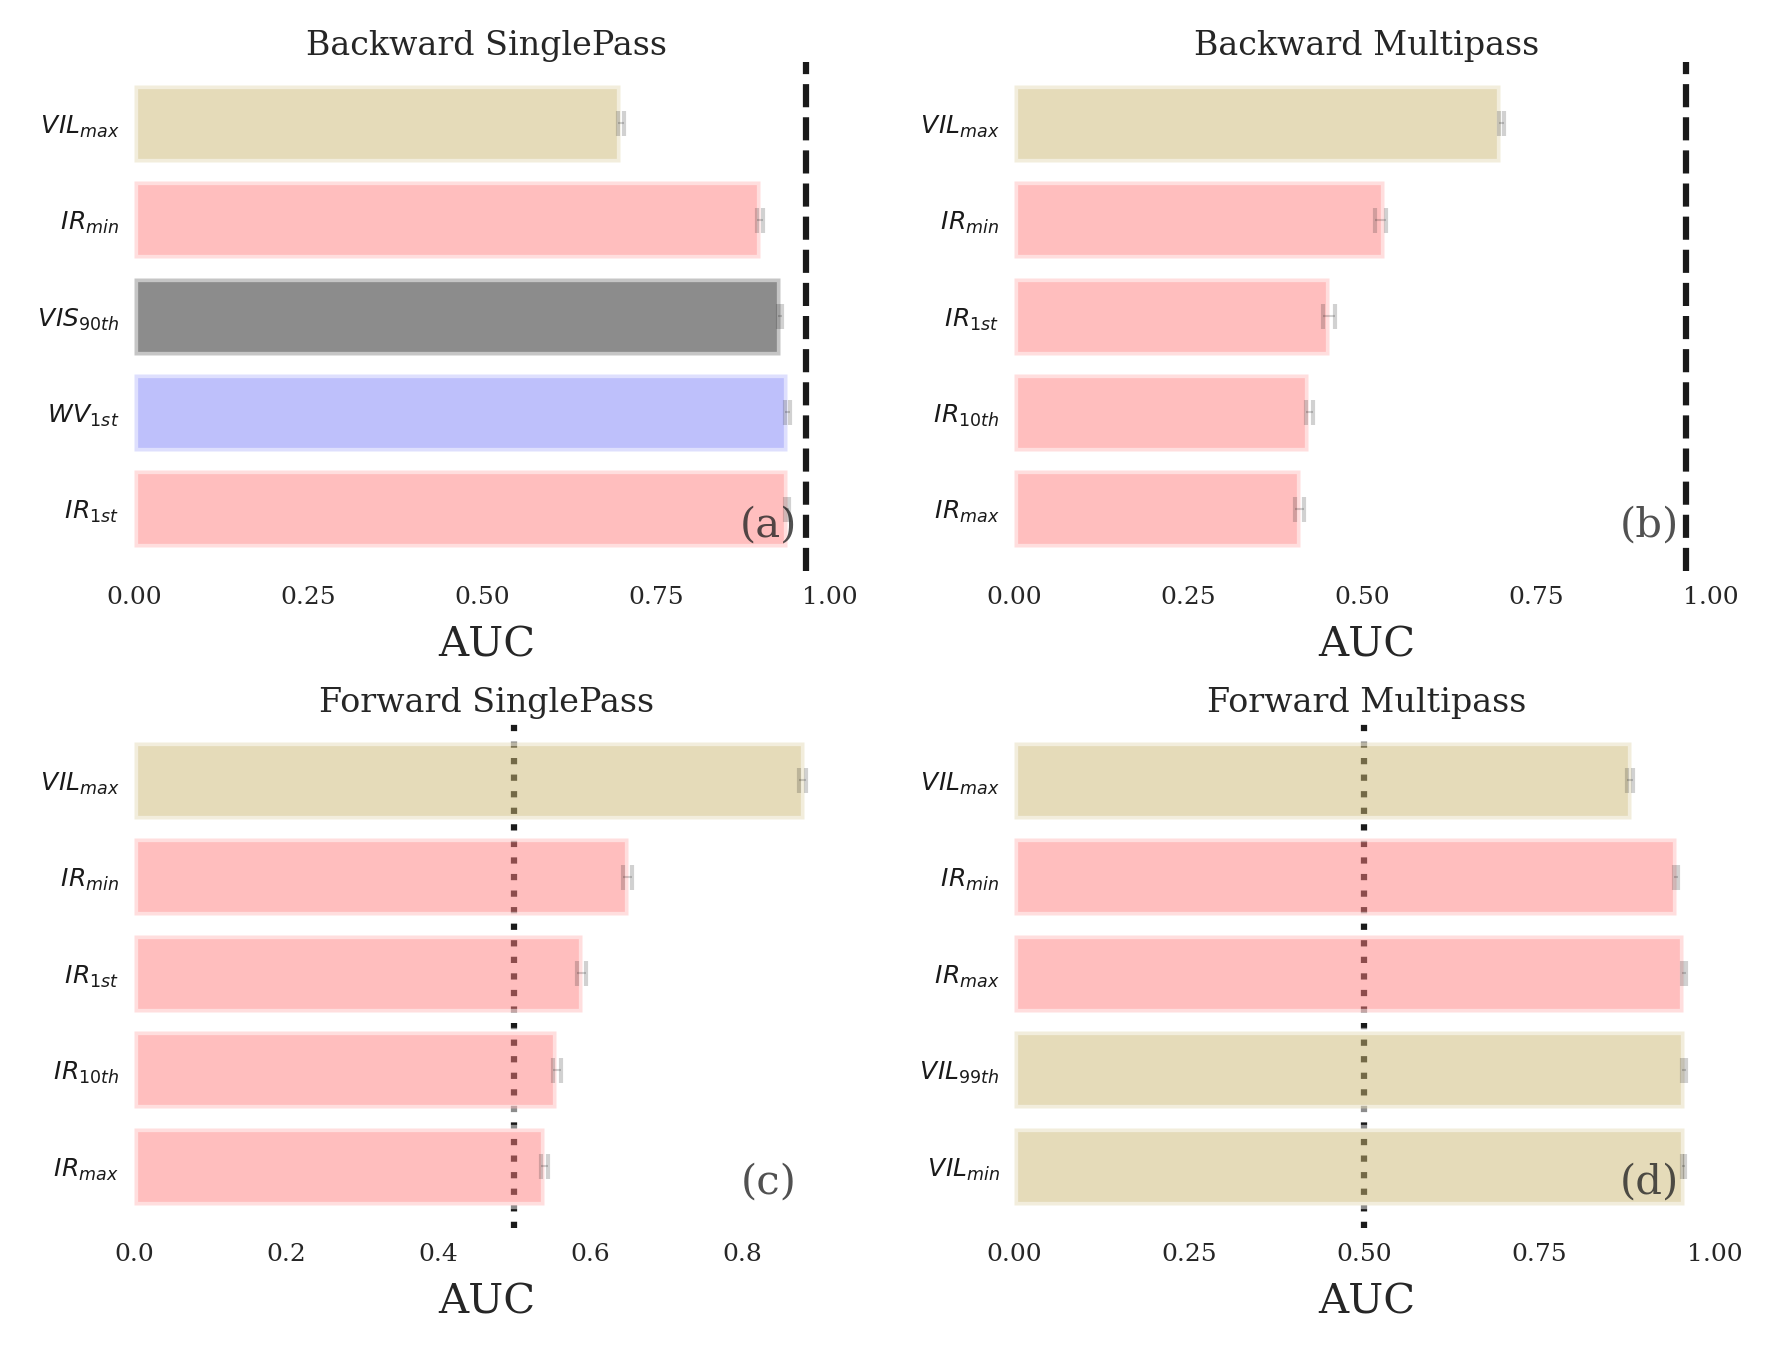

In [20]:
panels = [('backward_singlepass', 'LR'),
          ('backward_multipass',  'LR'),
          ('forward_singlepass', 'LR'),
          ('forward_multipass',  'LR'),
         ]

fig,axes = explainer.plot_importance(data=[results_backward, results_backward, 
                                           results_forward, results_forward], 
                                panels=panels,
                                num_vars_to_plot=5,
                                xlabels=['AUC']*len(panels),
                                display_feature_names=display_feature_names, 
                                feature_colors=color_dict, 
                                n_columns=2, 
                                 )

titles = ['Backward SinglePass', 'Backward Multipass', 
          'Forward SinglePass',  'Forward Multipass', 
         ]

for ax, title in zip(axes.flat, titles):
    ax.set_title(title, pad=0.02)

The color coding is as follows: 
1. Red : Infrared (IR) brightness temperature-based features
2. Purple: Water vapor (WV) brightness temperature-based features
3. Gold: Vertically integrated liquid (VIL)-based features

The consensus from the different permutation importance methods is that spatial-maximum VIL and the spatial-minimum infrared temperature features are the most important. This is an physically consistent result as high VIL values are associated with convective cores as are cold infrared temperatures. Beyond the top 2 features, there is only partial consensus amongst the different rankings. Remember that each method is measuring a slightly different aspect of feature importance and are not neccesarily expected to provide identical rankings. For example, backward-based methods are evaluating how model performance degrades as features are permuted while forward-based methods evaluate how much the model performance relies solely on those unpermuted features. 

For example, for the forward singlepass method, all features start permuted and then a single feature is unpermuted (repeated for each feature). In this case, with all features permuted expect VIL$_{max}$, the model achieved an AUC > 0.8. This result highlights that a majority of the model performance is based on VIL$_{max}$. For another example, for the backward multiplass, once a top feature is determined it is kept permuted before determining the next most important feature. In this case, once VIL$_{max}$ and IR$_{min}$ are both permuted, the model achieved an AUC of 0.5 indicating that all model performance is lost. This result does not mean that the other features are unimportant/useless. The correct interpretation is that the importance of the other features are heavily linked to VIL$_{max}$ and IR$_{min}$ and once the model can no longer rely on the covariate information of those features with VIL$_{max}$ and/or IR$_{min}$ (due to the permutations), their useful contributions are lost. 


Let's see in the next task whether these are truly the relationships learned by the logistic regression model. 

## Task 2. Analyze the Learned Relationships

To evaluate the learned relationships we use the accumuluted local effects rather than partial dependence.
For more details on the accumulated local effects, see this [tutorial notebook](https://github.com/monte-flora/scikit-explain/blob/master/tutorial_notebooks/accumulated_local_effect_tutorial.ipynb).


In [22]:
# Get the top 2 vars. 
important_vars = explainer.get_important_vars(results_backward, n_vars=2)['LR'][:2]
# Compute the ALE 
ale_1d_ds = explainer.ale(features=important_vars, subsample=0.25, n_jobs=2, n_bins=20)

  0%|          | 0/2 [00:00<?, ?it/s]

(<Figure size 1800x1200 with 6 Axes>,
 array([<AxesSubplot:xlabel='$VIL_{max}$'>,
        <AxesSubplot:xlabel='$IR_{min}$'>], dtype=object))

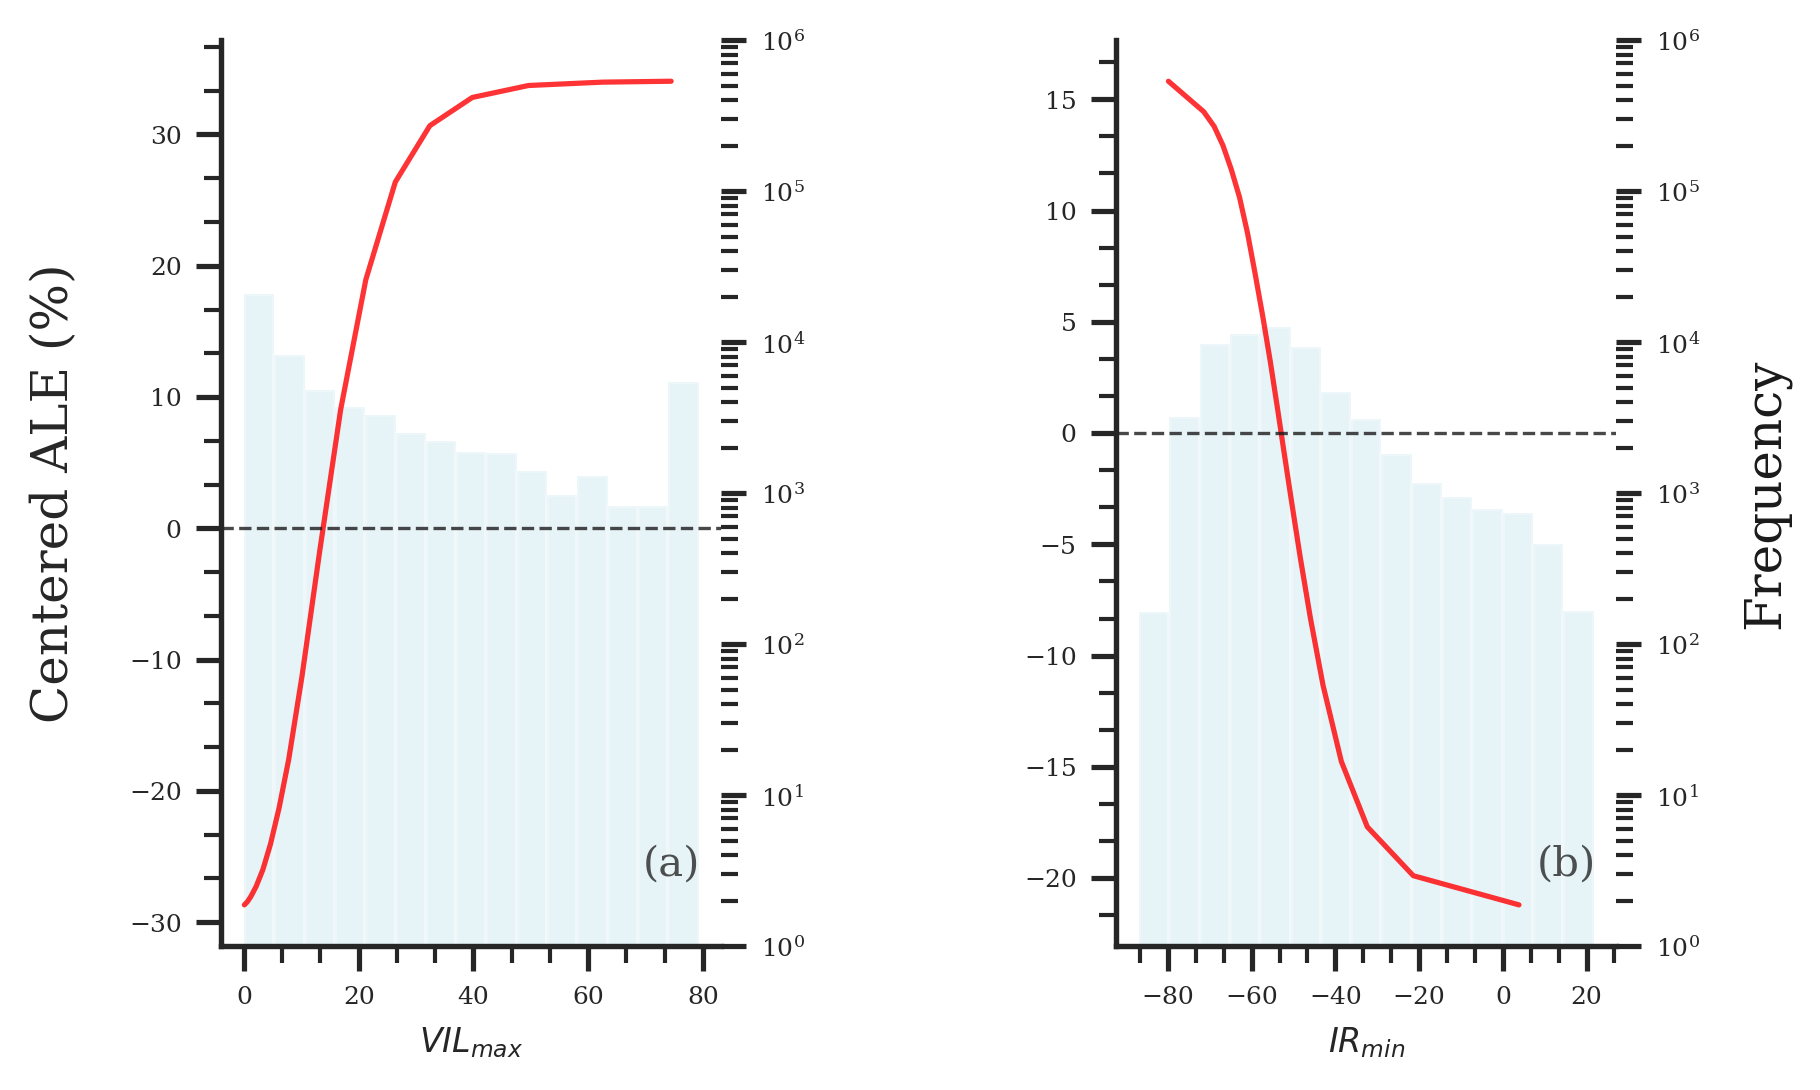

In [24]:
explainer.plot_ale(ale_1d_ds, display_feature_names=display_feature_names, figsize=(6,4))

Success! As mentioned in the previously task, we expect higher spatial-maximum VIL values to contribute positively to the model prediction while lower spatial-minimum infrared temperatures also contribute positively. At the moment, we know that the model is skillful and has learned physically sound relationships. Additionally, the model prediction is more sensitive to changes in VIL$_{max}$ (-30-30) than IR$_{min}$ (-20-15). The greater sensitive to VIL$_{max}$ helps explain why it is a more important feature. 

### Task 2a. (optional) Run the ALE code yourself. Also, run the PD code and plot both. 


 </div> <div class="alert alert-block alert-warning"><b>Question: </b> Are there difference between ALE and PD?</div>


## Task 3. Can we simplify the model? 

The ML models performed well on the testing datasets and the learned relationships were physically sound. Based on the permutation importance results, there was a strong consensus that spatial-maximum VIL and spatial-minimum IR were the most important features. Let's re-train the ML models on these two features and see if can maintain similar skill. If we can largely match the skill, then we have drastically improved the explainability by reducing the model to two variables.  

For automated tasks with little to no human intervention, we likely want to optimize model performance with little regard for explainability. For tasks where human decision making is required (e.g., high risk situations like severe weather forecasting), then we must balance model performance with model explainability. In some circumstances, we can greatly simplify a model without a significant loss of model performance. 



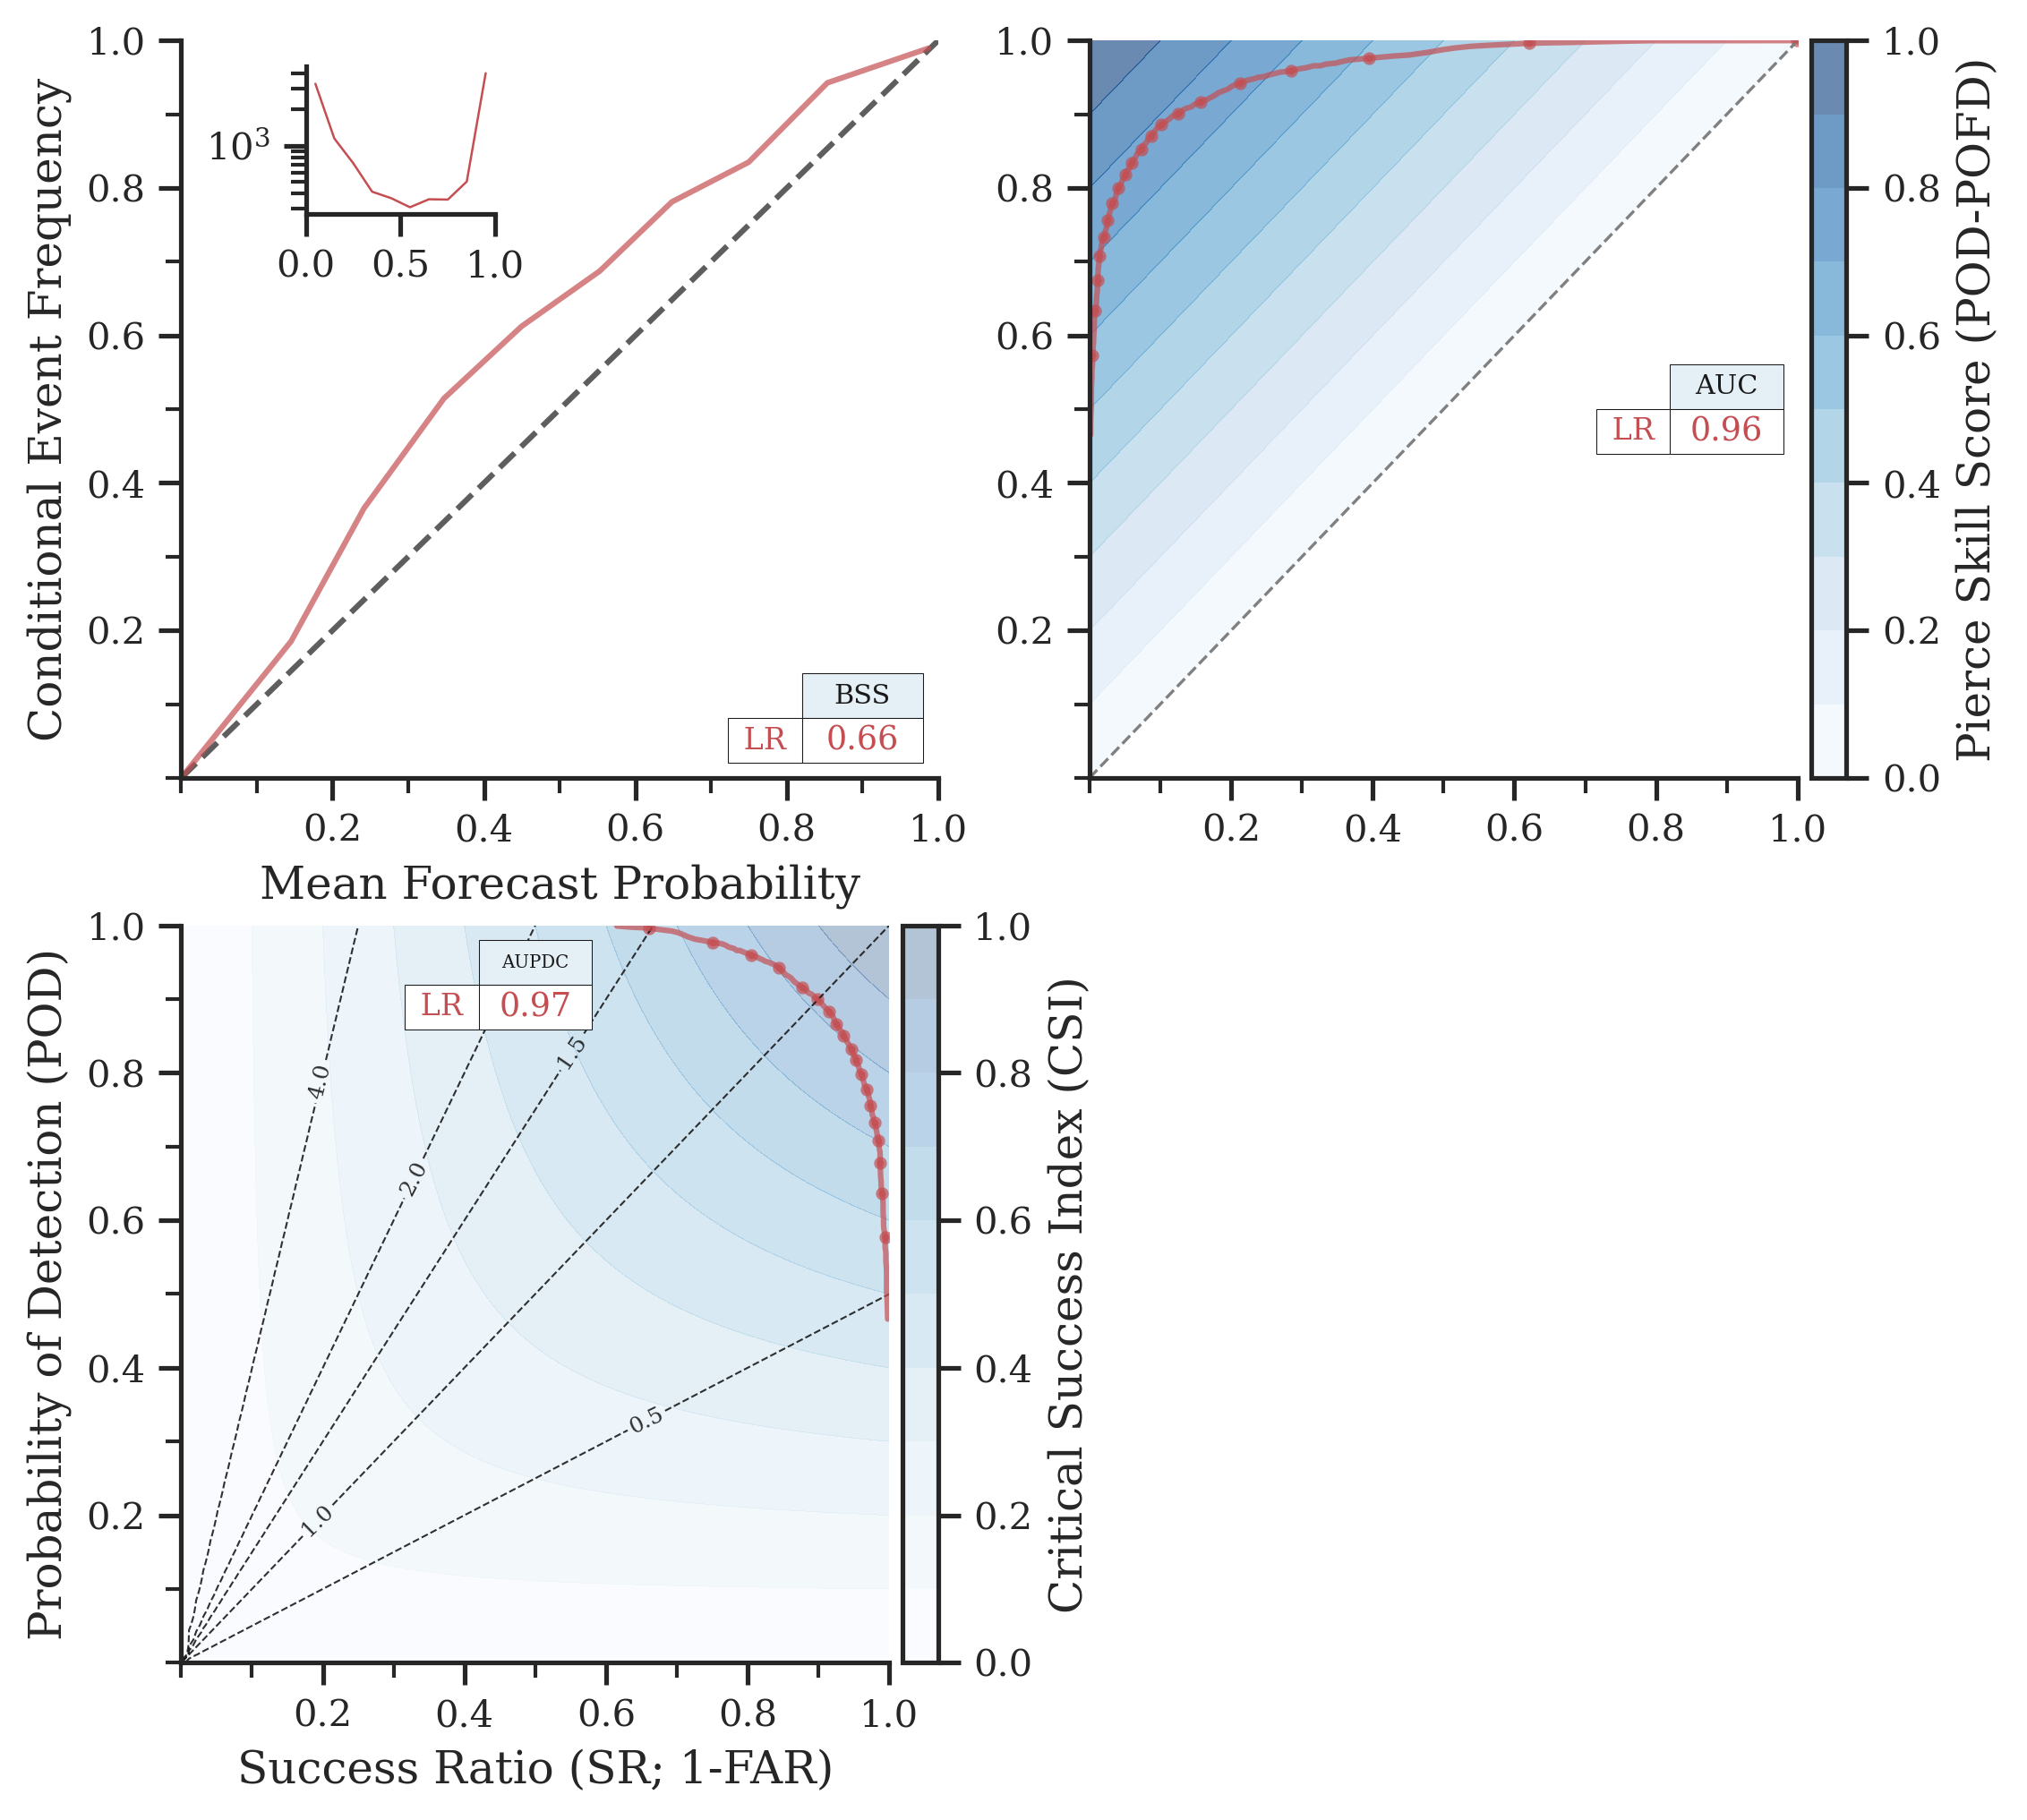

In [58]:
from sklearn.linear_model import LogisticRegression

X_train_sub = X_train[important_vars]
X_test_sub = X_test[important_vars]

X_train_sub.reset_index(drop=True, inplace=True)
X_test_sub.reset_index(drop=True, inplace=True)

lr = LogisticRegression()
lr.fit(X_train_sub, y_train)

plot_verification([('LR', lr)], X_test_sub, y_test.values)

Compared to the results in the [previous notebook](https://github.com/ai2es/tai4es-trustathon-2022/blob/main/severe/notebooks/Notebook_00a_Train_Classification_models.ipynb), the predictions have become slightly underconfident for probabilities > 40%, but the discrimination skill remains high with an AUDPC of 0.97 and AUC of 0.96. This result highlights that we can accurately predict whether an storm-centered image will contain lightning using only two variables! If this model were being developed for a task where human intervention was required, then we have a provided a model that is both highly accurate and understandable.  

 </div> <div class="alert alert-block alert-warning"><b>Question: </b> Can we explain why the reliability decreased, but the discrimination was unaffected? What does that tells about this simplified model? </div>
 
 </div> <div class="alert alert-block alert-warning"><b>Question: </b> If we kept only the spatial-minimum and maximum for each satellite variable (WV, IR, VIL, VI) and removed the other spatial percentile-based features, how does the model perform? Does the reliability improve? The spatial min and max features are interpretable, so we would still have an understandable model if we slightly increased the feature set.  </div>
 
 

## Task 4. Explain individual predictions

In Task 1 and 2, we explored global charactersistic of the model. We know that VIL$_{max}$ and IR$_{min}$ are the two main contributors to model performance and the learned relationships for both features is physically consistent. The model is not perfect and will make incorrect predictions. Can we use local explainability methods to understand what the typical false alarms or miss looks like? Can we anticipate failure modes? In the following example, we will use Shapley values to breakdown how each feature contributes to a single model prediction. Instead of looking at random examples, we will examine average contributions to the top 5 best hits (high confidence of lightning and lightning observed), worst false alarms (high confidence, but no lightning flash), worst misses (low confidence, but lightning flash was observed), and correct negatives (low confidence and no lightning flash occurred).


Unlike the global explainability, we are free to use the training or testing dataset for local explainability. For this task, we switch to testing dataset for the following examples.

In [59]:
results = explainer.local_contributions(method='shap', 
                                       performance_based=True,
                                       n_samples=5, 
                                       shap_kwargs={'masker' : 
                                      shap.maskers.Partition(X_train, max_samples=100, clustering="correlation"), 
                                     'algorithm' : 'auto'}
                                          )

In [76]:
from skexplain.common.contrib_utils import get_indices_based_on_performance

inds = get_indices_based_on_performance(estimators[0][1], X_test, y_test, 
                                        estimator_output='probability', n_samples=5)


In [77]:
len(y_test)

11493

In [79]:
inds['Worst Misses']

array([4859,  903,  906, 8087, 3490])

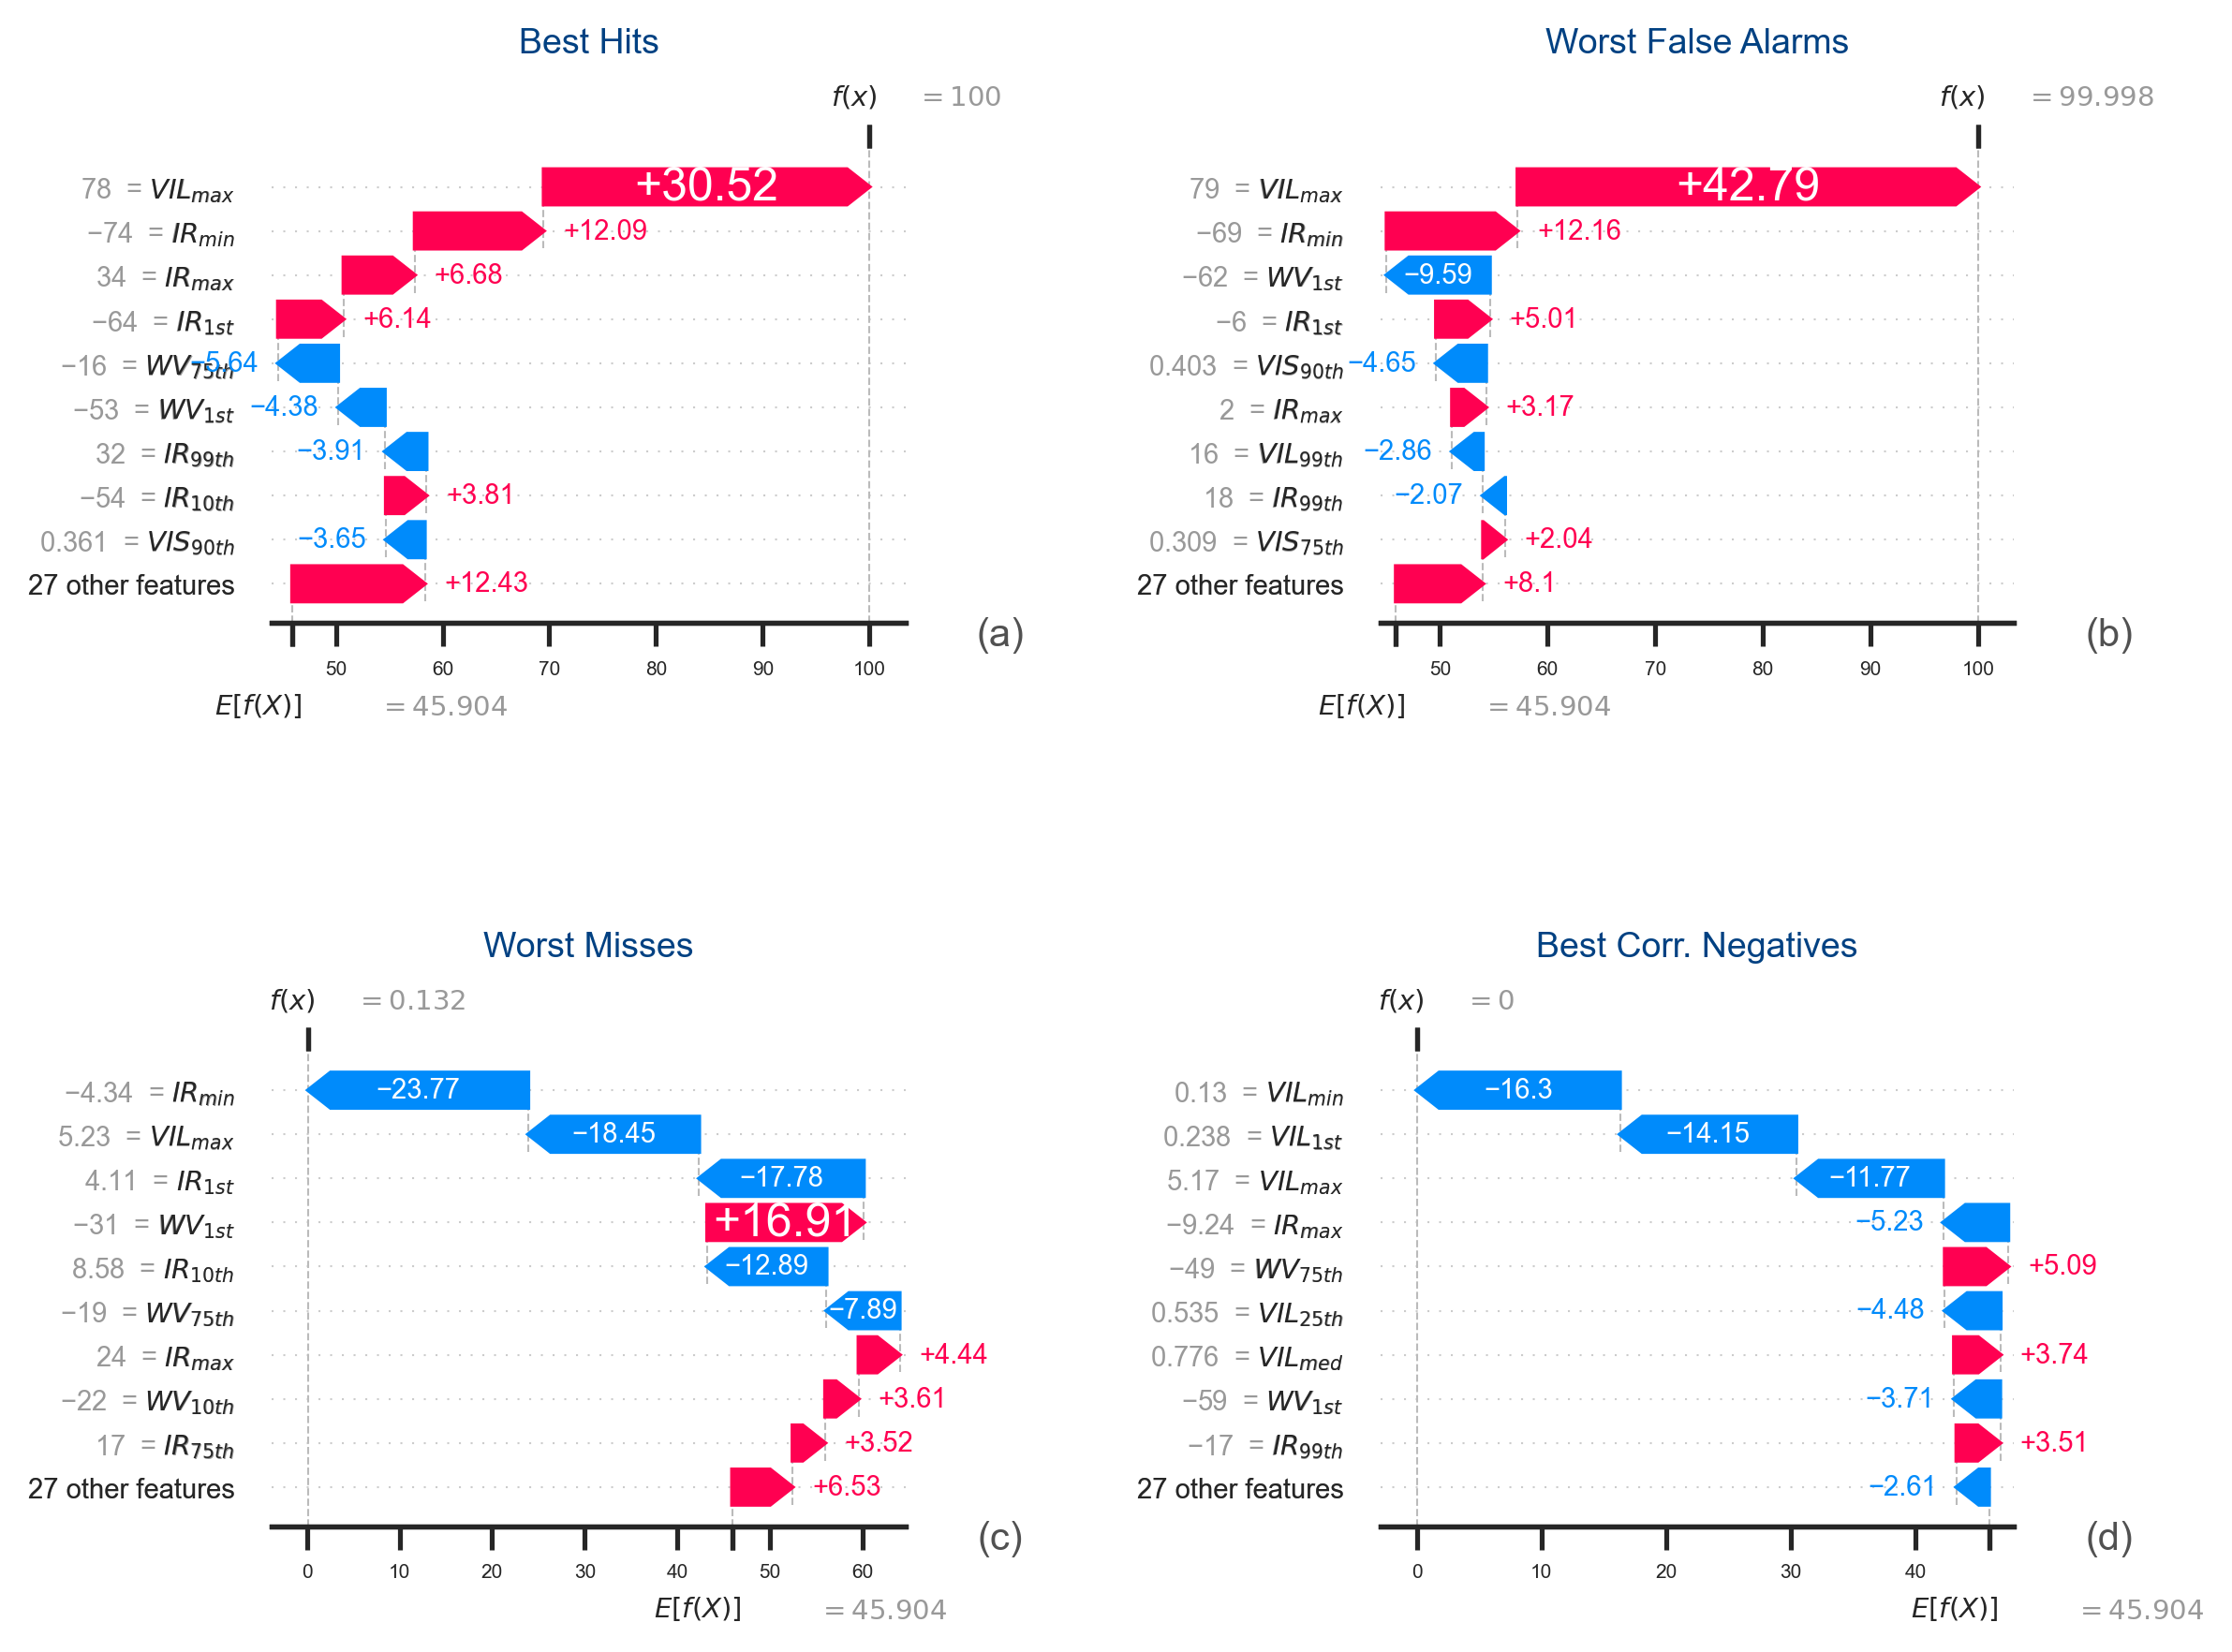

In [60]:
fig = explainer.plot_contributions(contrib=results,  
                            display_feature_names=display_feature_names,
                                   n_columns=2
                        )

The VIL$_{max}$ and IR$_{min}$ values (78 & 79 and -74 &-69, respectively) are comparable for the best hits and worst false alarms and they are the top contributors, which is consistent with the global results. Though we can include the files in this tutorial, we explored the dataset to determine the source of the false alarm. In the below animation, we can see that for two timesteps, there was a data outage as the GLM lightning flash data was missing. Thus, the false alarm in this case was likely a hit. 



In [85]:
from IPython.display import Video
Video("FalseAlarm.mp4")

In this next animation, we can see the cause of the worst misses. In this case, the IR temperatures were low in the region of observed lightning flashes, but the VIL data was missing, giving erroroeously low values. 

In [86]:
from IPython.display import Video
Video("another_miss.mp4")

In both the worst false alarm and worst misses, the cause was linked to missing or bad data and not neccesarily the ML model. Given the high accuracy of the model, it is probably fair to assume that the cause of other bad false alarms and misses are linked to dad or missing data.